<h1>Introduction</h1>
<img  src="https://upload.wikimedia.org/wikipedia/commons/a/a6/Dipole_xmting_antenna_animation_4_408x318x150ms.gif" align='right' alt="radio">
This notebook will explore using deep learning for radio signal classificaiton. <br><br>
Here is a link to the paper we referenced: <br> <a href="https://arxiv.org/pdf/1712.04578.pdf">Deep Learning for Signal Classification</a>
<br> <br>
The goal is to autonomously label radio data. This is useful in many applications including interference monitoring, radio fault detection, dynamic spectrum access, opportunistic mesh networking, many others. In the past 5 years, we have seen rapid disruption to this field from improvements in deep learning. Deep learning has increased the capacity for learning features directly  on raw high dimensional input data based on high level supervised objectives.

<h1>Import Libraries</h1>

In [1]:
import os
import pickle
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
from os.path import isfile, join

<h1>Load the Data</h1>

In [2]:
f = open("../data/signals/RML2016.10a_dict.pkl","rb")
data = pickle.load(f,encoding='latin1')
keys = list( data.keys())

# make ordered list of labels, signals, and SNR values
labels = []
signals = []
snrs = []
for i in range(len(keys)):
    #if keys[i][1] > 0:
    for j in range(len(data[keys[i]])):
        labels.append(keys[i][0])
        snrs.append(round(keys[i][1],2))
        signals.append(data[keys[i]][j])

snr_vals = list(set(snrs))
snr_vals.sort()
        
total = len(signals)
print(str(total) + ' Signals and Labels Loaded!')

# sample two signals of the same class with different SNR values
for i in range(len(signals)):
    if labels[i] == 'QPSK' and snrs[i] == -20:
        noisy = signals[i]
        break

for i in range(len(signals)):
    if labels[i] == 'QPSK' and snrs[i] == 18:
        clean = signals[i]

220000 Signals and Labels Loaded!
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


<h1>Plot Sample Signal</h1>

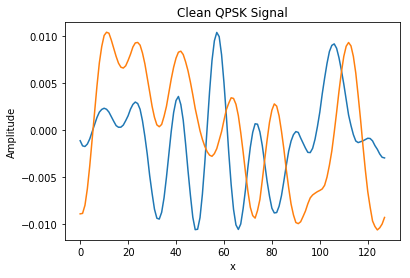

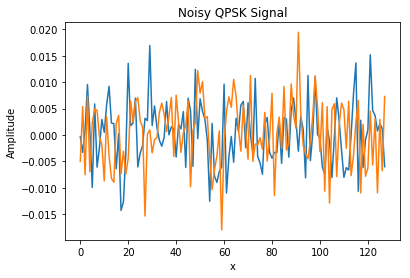

In [26]:
x = list(range(len(noisy[0])))

# plot training and validation loss history
plt.plot(x, clean[0])
plt.plot(x, clean[1])
plt.title('Clean QPSK Signal')
plt.xlabel('x')
plt.ylabel('Amplitude')
plt.show()

# plot training and validation loss history
plt.plot(x, noisy[0])
plt.plot(x, noisy[1])
plt.title('Noisy QPSK Signal')
plt.xlabel('x')
plt.ylabel('Amplitude')
plt.show()

<h1>One-Hot Encode Labels</h1>

In [4]:
classes = list(set(labels))
print('Signal Classes: ')
print(classes, '\n')

# create one-hot encoding 
one_hot = []
for i in range(len(classes)):
    t = []
    for j in range(len(classes)):
        if j != i:
            t.append(0)
        else:
            t.append(1)
    one_hot.append(t)
one_hot = np.asarray(one_hot)

# create dictonaries for encoding and decoding classes to one-hot labels
encode = {}
for i in range(len(classes)):
    encode[classes[i]] = one_hot[i]
decode = {}
for i in range(len(one_hot)):
    decode[str(one_hot[i])] = classes[i]

nums = list(range(10))
num2class = {}
for i in range(len(nums)):
    num2class[str(nums[i])] = classes[i]

# encode labels to one-hot
for i in range(len(labels)):
    labels[i] = encode[labels[i]]

Signal Classes: 
['QAM64', 'AM-SSB', 'BPSK', 'CPFSK', 'QAM16', 'WBFM', 'QPSK', 'AM-DSB', 'GFSK', '8PSK', 'PAM4'] 



<h1>Shuffle and Partition Data</h1>

In [15]:
# choose every 8th data point as testing data
train_idx = list(range(total))
test_idx = []
num = int(total / 8)
for i in range(num):
    test_idx.append(i*8)
train_idx = list(set(train_idx)-set(test_idx))

# shuffle indices
shuffle(train_idx)
shuffle(train_idx)
shuffle(train_idx)
shuffle(test_idx)
shuffle(test_idx)
shuffle(test_idx)

# split validation and testing data
val = int(len(test_idx)/2)
val_idx = test_idx[val:]
del test_idx[val:]

# assign training data
x_train = []
y_train = []
for i in range(len(train_idx)):
    x_train.append(signals[train_idx[i]])
    y_train.append(labels[train_idx[i]])
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

# assign validation data
x_val =  []
y_val = []
for i in range(len(val_idx)):
    x_val.append(signals[val_idx[i]])
    y_val.append(labels[val_idx[i]])
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

# assign testing data
x_test =  []
y_test = []
test_snrs = []
for i in range(len(test_idx)):
    x_test.append(signals[test_idx[i]])
    y_test.append(labels[test_idx[i]])
    test_snrs.append(snrs[test_idx[i]])
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

print('Data has been split into training and testing data! \n')
print('Shape of Signal Data: ', x_train[0].shape, '\n')
print('Number of training examples: ',len(x_train))
print('Number of validation examples: ',len(x_val))
print('Number of testing examples: ',len(x_test), '\n')

Data has been split into training and testing data! 

Shape of Signal Data:  (2, 128) 

Number of training examples:  192500
Number of validation examples:  13750
Number of testing examples:  13750 



<h1>
    Convolutional Model
</h1>
<p1>
    <strong>Convolutional NN Models</strong> were developed for image classification problems where a model<br>
    learns an internal representation of a two-dimensional input, a process referred to as <strong>feature learning.</strong><br><br>
    This same process can be harnessed on one-dimensional data, such as radio signal time series data.<br>
    The model learns to extract features from sequences of observations and how to map the internal features<br>
    to different activity types.<br><br>
    The benefit to using CNNs for time series classification is that they can learn from the raw data directly<br>
    and do not require domain expertise. The model can learn an internal representation of the time series data<br>
    and ideally achieve competetive results.
</p1>

<h1>Thinking About the Data</h1>
<p1>
    There are <strong>two main signal types</strong> in the raw data: I signals and Q signals. Each time series data<br>
    has been partitioned into 1024 steps. Thus, one row of data has 1024 elements
</p1>
<br>

<p1>
    Each data is paired with a one-hot encoded label.
</p1>

<h1>Defining the Model Using Keras</h1>
<p1>Once our data is loaded and ready for modeling, we can define, fit, and evalute a CNN model.
    We can define a function named <b>evaluate_model()</b> that takes the train / testing sets, fits a 
    model to the training set, evaluates it on the test dataset, and returns an estimate of the model performance.
    <br><br>
    First we must define the CNN using Keras. There are 1024 time steps, a total of two variables for each time step and
    one sample. We load all the data for a given group into a single 3-D numpy array where the dimensions are <b>[samples, time steps, features]</b>
    <br><br>
    One sample is one <i>window</i> of the time series data, each window has 1024 timesteps, and a time step has two variable features.
    <br><br>
    The output of the model will be a 24 element vector containing the probability of a given window belonging to each of the <b>24 signal</b> types. The input and output dimensions are required when fitting the model, and we can extract them from the dataset.
    <br><br>
    The model is defined by the Sequential Keras model. We will define the model as having two <b>1D CNN layers</b>, followed by a <b>dropout layer</b> for regularization. Then a <b>pooling layer</b> is added. It is common to define CNN layers in groups of 2 in order to give the model a good chance of learning features from the input data. CNNs learn very quickly, so the dropout layer is intended to slow down the learning process and result in a better final model. The pooling layer reduces the learned features to a fourth of its size, consolidating them to only the most essential elements.<br><br>
    After the CNN and pooling, the learned features are <b>flattened</b> into one long vector and passed through a <b>fully connected layer</b> before the output layer is used to make a prediction. The fully connected layer ideally provides a buffer between learned features and the output ith the intent of interpretting the learned features before makeing a prediction.
    <br><br>
    For this model, we will use a standard configuration of <b>64 parallel feature maps</b> and a <b>kernal of size 3.</b> The <b>feature maps</b> are the <i>number of times the input is processed or interpretted</i> whereas the <b>kernel size</b> is <i>the number of input time steps considered as the input sequence is read or processed onto the feature maps</i>.
    <br><br>
    The efficient <b>Adam</b> version of stochastic gradient descent will be used to optimize the network, and the <b>categorical cross entropy</b> loss function will be used given that we are learning a <b>multi-class classification</b> problem.
</p1>

<h1>Import Deep Learning Libraries</h1>

In [6]:
import keras.models as models
from keras.regularizers import *
from keras.utils import np_utils
from keras.optimizers import adam
from keras.layers.noise import GaussianNoise
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, ZeroPadding3D

Using TensorFlow backend.


In [7]:
in_shp = list(x_train.shape[1:])
print('Input Shape:', in_shp)

dr = 0.5
nb_epoch = 10
batch_size = 1024 

Input Shape: [2, 128]


In [8]:
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D(padding=(0, 2), data_format="channels_first"))
model.add(Conv2D(256, (1, 3), activation="relu", name="conv1", padding="valid", kernel_initializer="glorot_uniform", data_format="channels_first"))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2), data_format="channels_first"))
model.add(Conv2D(80, (2, 3), activation="relu", name="conv2", padding="valid",data_format='channels_first', kernel_initializer="glorot_uniform"))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation="relu", name="dense1", kernel_initializer="he_normal"))
model.add(Dropout(dr))
model.add(Dense(len(classes), name="dense2", kernel_initializer="he_normal"))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

W0806 17:11:23.755398 139733483657024 deprecation_wrapper.py:119] From /home/desserteagle/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0806 17:11:23.780899 139733483657024 deprecation_wrapper.py:119] From /home/desserteagle/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0806 17:11:23.791589 139733483657024 deprecation_wrapper.py:119] From /home/desserteagle/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0806 17:11:23.803354 139733483657024 deprecation_wrapper.py:119] From /home/desserteagle/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 2, 132)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 2, 130)       1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 2, 130)       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 256, 2, 134)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 80, 1, 132)        122960    
_________________________________________________________________
dropout_2 (Dropout)          (None, 80, 1, 132)        0         
__________

<h1>Train Model</h1>

In [9]:
history = model.fit(x_train,
    y_train,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    validation_data=(x_val, y_val),
                  )

/home/desserteagle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """
W0806 17:11:24.129096 139733483657024 deprecation.py:323] From /home/desserteagle/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 192500 samples, validate on 13750 samples
Epoch 1/10
192500/192500 [==============================] - 239s 1ms/step - loss: 2.1652 - acc: 0.1837 - val_loss: 1.9842 - val_acc: 0.2599
Epoch 2/10
192500/192500 [==============================] - 239s 1ms/step - loss: 1.8910 - acc: 0.2981 - val_loss: 1.7226 - val_acc: 0.3743
Epoch 3/10
192500/192500 [==============================] - 239s 1ms/step - loss: 1.6813 - acc: 0.3743 - val_loss: 1.5473 - val_acc: 0.4206
Epoch 4/10
192500/192500 [==============================] - 239s 1ms/step - loss: 1.5711 - acc: 0.4091 - val_loss: 1.4788 - val_acc: 0.4436
Epoch 5/10
192500/192500 [==============================] - 238s 1ms/step - loss: 1.5021 - acc: 0.4313 - val_loss: 1.3884 - val_acc: 0.4756
Epoch 6/10
192500/192500 [==============================] - 238s 1ms/step - loss: 1.4550 - acc: 0.4464 - val_loss: 1.3628 - val_acc: 0.4850
Epoch 7/10
192500/192500 [==============================] - 239s 1ms/step - loss: 1.4324 - acc: 0.4516 - val_

<h1>Plot Evalutation Testing Data</h1>

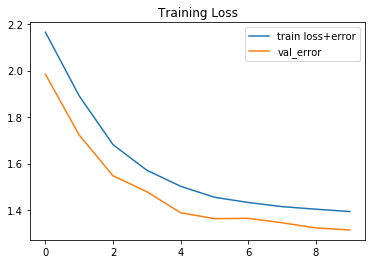

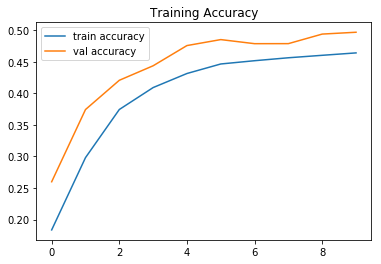

In [25]:
plt.figure()
plt.title('Training Loss')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()
plt.show()

plt.figure()
plt.title('Training Accuracy')
plt.plot(history.epoch, history.history['acc'], label='train accuracy')
plt.plot(history.epoch, history.history['val_acc'], label='val accuracy')
plt.legend()
plt.show()

<h1>Plot Confusion Matrix</h1>

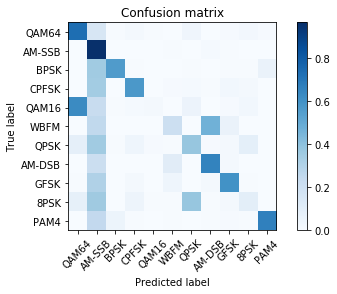

In [14]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot confusion matrix
test_Y_hat = model.predict(x_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,x_test.shape[0]):
    j = list(y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

<h1>Get Accuracy for Each SNR</h1>
<p1>
    Here we take a look at how the accuracy of our model improves as the quality of our data improves.
<p1>

In [21]:
# for each snr value, create a list of indices 
snr_accuracies = {}
for i in range(len(snr_vals)):
    listylist = []
    for j in range(len(test_snrs)):
        if test_snrs[j] == snr_vals[i]:
            listylist.append(j)
    snr_accuracies[str(snr_vals[i])] = listylist

# compute average accuracy for each snr value
for i in range(len(snr_vals)):
    snr = str(snr_vals[i])
    indices = snr_accuracies[snr]
    test_data = np.asarray([x_test[i] for i in indices])
    test_label = np.asarray([y_test[i] for i in indices])
    test_loss, my_acc = model.evaluate(test_data, test_label, batch_size=batch_size)
    snr_accuracies[snr] = my_acc

708/708 [==============================] - 0s 276us/step


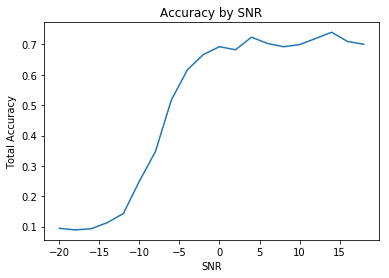

In [19]:
my_accs = []
for i in range(len(snr_vals)):
    my_accs.append(snr_accuracies[str(snr_vals[i])])
       
# plot signal
plt.plot(snr_vals, my_accs)
#plt.xlim(0,2)
plt.title('Accuracy by SNR')
#plt.xticks([], [])
#plt.yticks([], [])
plt.xlabel('SNR')
plt.ylabel('Total Accuracy')
plt.show()